In [1]:
import csv
import collections
import re
import html.parser
import json

import requests
import pandas
import numpy
import seaborn
import matplotlib.pyplot as plt

%matplotlib inline

## Read entrez gene

In [2]:
# read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/a7362748a34211e5df6f2d185bb3246279760546/data/genes-human.tsv'
entrez_df = pandas.read_table(url, dtype={'GeneID': str})
human_genes = set(entrez_df.GeneID)
human_coding_genes = set(entrez_df[entrez_df.type_of_gene == 'protein-coding'].GeneID)

In [3]:
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/a7362748a34211e5df6f2d185bb3246279760546/data/symbol-map.json'
symbol_to_entrez = json.loads(requests.get(url).text)
symbol_to_entrez = {k: str(v) for k, v in symbol_to_entrez.items()}

## GMT functions

In [4]:
def read_gmt(path):
    read_file = open(path)
    reader = csv.reader(read_file, delimiter='\t')
    for row in reader:
        if not row:
            continue
        name = row[0]
        description = row[1]
        genes = set(row[2:])
        yield name, description, genes
    read_file.close()

## Resource downloads

In [5]:
# download WikiPathways
url = 'http://www.pathvisio.org/data/bots/gmt/wikipathways.gmt'
! wget --timestamping --no-verbose --directory-prefix=download $url

# download Pathway Commons v7
url = 'http://www.pathwaycommons.org/pc2/downloads/Pathway%20Commons.7.All.GSEA.hgnc.gmt.gz'
! wget --timestamping --no-verbose --directory-prefix=download $url
! gunzip --force "download/Pathway Commons.7.All.GSEA.hgnc.gmt.gz"

2016-04-02 14:43:35 URL:http://www.pathwaycommons.org/pc2/downloads/Pathway%20Commons.7.All.GSEA.hgnc.gmt.gz [497424/497424] -> "download/Pathway Commons.7.All.GSEA.hgnc.gmt.gz" [1]


## Parse Pathway Commons

In [6]:
i = 0
rows = list()
PC_Row = collections.namedtuple('PC_Row', ['identifier', 'name', 'source', 'genes'])
path = "download/Pathway Commons.7.All.GSEA.hgnc.gmt"
for name, description, genes in read_gmt(path):
    
    # Process name
    name = re.sub(r'^9606: +', '', name)
    name = html.parser.unescape(name)
    if name == 'Not pathway':
        continue
    
    # Process description
    description = dict(item.split(': ') for item in description.split('; '))
    if description['organism'] != '9606':
        continue
    
    # Convert genes to Entrez
    genes = {symbol_to_entrez.get(x) for x in genes}
    genes.discard(None)
    if not genes:
        continue
    
    # Add pathway
    i += 1    
    row = PC_Row(
        identifier = 'PC7_{}'.format(i),
        name = name,
        source = description['datasource'],
        genes = genes,
    )
    rows.append(row)
    
pc_df = pandas.DataFrame(rows)
pc_df.head(2)

,identifier,name,source,genes
0,PC7_1,5-Hydroxytryptamine biosynthesis,panther,"{7166, 121278, 1644}"
1,PC7_2,5-Hydroxytryptamine degredation,panther,"{224, 4128, 4129, 218, 8854}"


In [7]:
pc_df.source.value_counts()

ctd           11006
reactome       1566
humancyc        285
pid             223
panther         148
kegg             83
mirtarbase        5
recon x           1
Name: source, dtype: int64

In [8]:
# Filter by provider (source)
keep = {'reactome', 'pid'}
pc_df = pc_df.query("source in @keep")
len(pc_df)

1789

In [9]:
source_to_license = {
    'reactome': 'CC BY 4.0',
    'pid': 'CC0 1.0',
}
pc_df['license'] = pc_df['source'].map(source_to_license)
pc_df.head(2)

,identifier,name,source,genes,license
609,PC7_610,2-LTR circle formation,reactome,"{3159, 7518, 3981, 7520, 2547, 11168, 8815}",CC BY 4.0
684,PC7_685,3' -UTR-mediated translational regulation,reactome,"{6218, 6205, 6129, 6122, 1973, 6126, 6229, 273...",CC BY 4.0


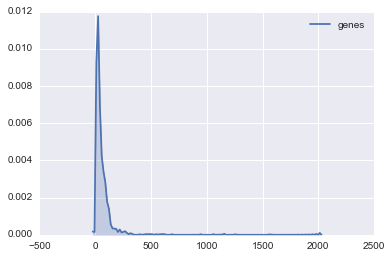

In [10]:
# Density plot of genes per pathway
seaborn.kdeplot(pc_df.genes.map(len), shade=True);

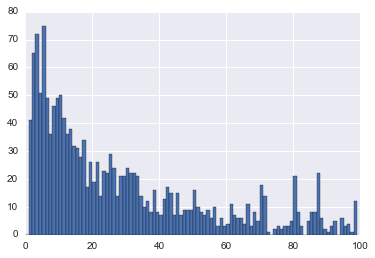

In [11]:
# Histogram of genes per pathway
plt.hist(pc_df.genes.map(len), numpy.arange(100));
plt.xlim(0, 100);

## Parse WikiPathways

In [12]:
gmt_generator = read_gmt('download/wikipathways.gmt')
wikipath_df = pandas.DataFrame(gmt_generator, columns = ['name', 'description', 'genes'])
wikipath_df.name = wikipath_df.name.map(lambda x: x.split('%')[0])
len(wikipath_df)

1317

In [13]:
# Remove genes absent from our entrez gene version
for genes in wikipath_df.genes:
    genes &= human_genes
wikipath_df = wikipath_df[wikipath_df.genes.map(bool)]
len(wikipath_df)

299

In [14]:
wikipath_df.head(2)

,name,description,genes
850,Tryptophan metabolism,http://www.wikipathways.org/instance/WP465_r79226,"{38, 3620, 1644, 3033, 3028, 8854, 1892, 6999,..."
851,Steroid Biosynthesis,http://www.wikipathways.org/instance/WP496_r69016,"{3295, 3294, 3284, 3292, 1586, 3283, 1369, 216..."


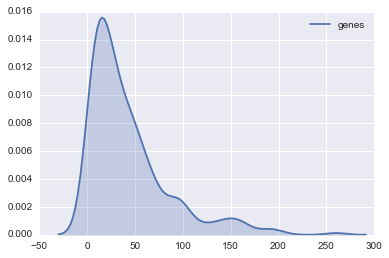

In [15]:
# Density plot of genes per pathway
seaborn.kdeplot(wikipath_df.genes.map(len), shade=True, );

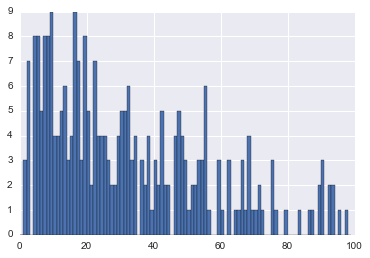

In [16]:
# Histogram of genes per pathway
plt.hist(list(wikipath_df.genes.map(len)), numpy.arange(100));
plt.xlim(0, 100);

In [17]:
wikipath_df = pandas.DataFrame({
    'identifier': wikipath_df['description'].map(lambda x: x.rsplit('/', 1)[1]),
    'name': wikipath_df['name'],
    'url': wikipath_df['description'],
    'source': 'wikipathways',
    'license': 'CC BY 3.0',
    'genes': wikipath_df.genes
})
wikipath_df.head(2)

,genes,identifier,license,name,source,url
850,"{38, 3620, 1644, 3033, 3028, 8854, 1892, 6999,...",WP465_r79226,CC BY 3.0,Tryptophan metabolism,wikipathways,http://www.wikipathways.org/instance/WP465_r79226
851,"{3295, 3294, 3284, 3292, 1586, 3283, 1369, 216...",WP496_r69016,CC BY 3.0,Steroid Biosynthesis,wikipathways,http://www.wikipathways.org/instance/WP496_r69016


## Merge resources into a pathway dataframe

In [18]:
pathway_df = pandas.concat([wikipath_df, pc_df])
pathway_df = pathway_df[['identifier', 'name', 'url', 'source', 'license', 'genes']]
len(pathway_df)

2088

In [19]:
# Remove duplicate pathways
pathway_df.genes = pathway_df.genes.map(frozenset)
pathway_df = pathway_df.drop_duplicates(['genes'])
len(pathway_df)

1862

In [20]:
pathway_df['coding_genes'] = pathway_df.genes.map(lambda x: x & human_coding_genes)

In [21]:
pathway_df.insert(3, 'n_genes', pathway_df.genes.map(len))
pathway_df.insert(4, 'n_coding_genes', pathway_df.coding_genes.map(len))

In [22]:
pathway_df = pathway_df.sort_values('identifier')
pathway_df.head()

,identifier,name,url,n_genes,n_coding_genes,source,license,genes,coding_genes
10398,PC7_10399,a4b7 Integrin signaling,NaN,8,8,pid,CC0 1.0,"(5747, 3688, 3676, 387, 3695, 5829, 7412, 8174)","(5747, 3688, 3676, 387, 3695, 5829, 7412, 8174)"
10399,PC7_10400,a6b1 and a6b4 Integrin signaling,NaN,45,45,pid,CC0 1.0,"(3688, 7533, 3911, 6257, 207, 840, 6256, 5376,...","(3688, 7533, 3911, 6257, 207, 5376, 840, 6256,..."
10441,PC7_10442,activated TAK1 mediates p38 MAPK activation,NaN,17,17,reactome,CC BY 4.0,"(257397, 8767, 8517, 3654, 5608, 6885, 5600, 1...","(257397, 9261, 8767, 7189, 8517, 64127, 10454,..."
10507,PC7_10508,alpha-linolenic (omega3) and linoleic (omega6)...,NaN,11,11,reactome,CC BY 4.0,"(51, 6342, 3295, 10005, 54898, 60481, 30, 215,...","(51, 10005, 3295, 6342, 54898, 60481, 30, 215,..."
10556,PC7_10557,amb2 Integrin signaling,NaN,32,32,pid,CC0 1.0,"(4313, 1490, 3569, 3055, 4620, 58494, 6093, 43...","(4313, 1490, 3569, 3055, 4620, 58494, 6093, 43..."


In [23]:
pathway_df.source.value_counts()

reactome        1341
wikipathways     298
pid              223
Name: source, dtype: int64

In [24]:
# Create a dataframe for writing as a tsv. Multi-element fields are pipe delimited.
write_df = pathway_df.copy()
join = lambda x: '|'.join(map(str, sorted(x)))
for column in 'genes', 'coding_genes':
    write_df[column] = write_df[column].map(join)

write_df.to_csv('data/pathways.tsv', index=False, sep='\t')